# Absolute permeability calulations

In [1]:
try:
    import numpy as np
    assert np.__version__=='1.20.0',"Please note that this code is only tested on numpy 1.20"
    import openpnm as op
    import porespy as ps
    assert op.__version__ == '2.8.2',"Please note that this code is only tested on openpnm 2.8.2"
    from openpnm.network import GenericNetwork
    from openpnm.geometry import Imported
    from openpnm.io import GenericIO
    from openpnm.models import physics as mods
    import matplotlib.pyplot as plt
    import bz2
    import pickle
    import _pickle as cPickle
except:
    import sys
    !{sys.executable} -m pip install numpy==1.20.0 matplotlib openpnm==2.8.2 porespy==1.3.1
    import openpnm as op
    from openpnm.network import GenericNetwork
    from openpnm.geometry import Imported
    from openpnm.io import GenericIO
    from openpnm.models import physics as mods
    import matplotlib.pyplot as plt
    import numpy as np
    import bz2
    import pickle
    import _pickle as cPickle

In [2]:
ws = op.Workspace()
ws.clear()
r_max = 5
sigma = 0.35
fname = 'Berea700_r'+str(r_max)+'_sigma'+str(int(sigma*100))

In [3]:
# old way of importing things
# =============================================================================
# import pickle as pk
# net = pk.load(open(fname + '.dict', 'rb'))
# pn = op.network.GenericNetwork()
# pn.update(net)
# geom = op.geometry.Imported(network=pn)
# prj = pn.project
# prj = op.io.PoreSpy.load(fname + '.dict')
# pn = prj.network
# geom = prj.geometries()['geo_01']

In [4]:
def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data
data = decompress_pickle(fname+'.pbz2') 

network = GenericNetwork(project=None)
network = GenericIO._update_network(network=network, net=data)
Imported(network=network, settings={})
prj = network.project
pn = prj.network
geom = prj.geometries()['geo_01']

In [5]:
# trim isolated clusters
# =============================================================================

In [6]:
net_health = pn.check_network_health()
op.topotools.trim(network=pn, pores=net_health["trim_pores"])

In [7]:
# Plotting the network
# =============================================================================

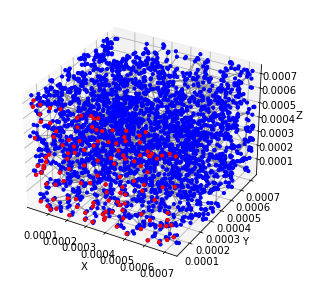

In [8]:
ax = op.topotools.plot_connections(network=pn, alpha=0.8, color='grey')
ax = op.topotools.plot_coordinates(network=pn, ax=ax, color='b', markersize=10)
ax = op.topotools.plot_coordinates(network=pn, pores=pn.pores('front'), ax=ax, color='r', markersize=10)

In [9]:
# Modifying pore network 
# =============================================================================

In [10]:
del geom['pore.area']
del geom['pore.volume']
del geom['throat.conduit_lengths.pore1']
del geom['throat.conduit_lengths.pore2']
del geom['throat.conduit_lengths.throat']
del geom['throat.endpoints.tail']
del geom['throat.endpoints.head']


geom['throat.volume'] = np.zeros(geom['throat.volume'].shape)
geom.add_model(propname='pore.volume',
                model=op.models.geometry.pore_volume.sphere)
geom['pore.volume'][pn.pores('boundary')] = 0
geom.add_model(propname='throat.endpoints',
                model=op.models.geometry.throat_endpoints.spherical_pores)
geom.add_model(propname='pore.area',
                model=op.models.geometry.pore_area.sphere)
geom.add_model(propname='throat.conduit_lengths',
                model=op.models.geometry.throat_length.conduit_lengths)

In [11]:
# defining the fluid
# =============================================================================

In [12]:
oil = op.phases.GenericPhase(network=pn)
oil['throat.contact_angle'] = 180 
oil['pore.contact_angle'] = 180
oil['throat.surface_tension'] = 20e-3
oil['pore.surface_tension'] = 20e-3
oil['throat.viscosity'] = 0.8e-3
oil['pore.viscosity'] = 0.8e-3

In [13]:
# defining the physics
# =============================================================================

In [14]:
phys = op.physics.GenericPhysics(network=pn, phase=oil, geometry=geom)
phys.add_model(propname='throat.entry_pressure',
                model=mods.capillary_pressure.washburn)
phys['pore.entry_pressure'] = 0
phys.add_model(propname='throat.flow_shape_factors',
               model=mods.flow_shape_factors.conical_frustum_and_stick)
phys.add_model(propname='throat.hydraulic_conductance',
               model=mods.hydraulic_conductance.hagen_poiseuille)

In [15]:
# calculating permeability
# =============================================================================

The permeability coefficient from top to bottom is: [4.52960094e-13]
The permeability coefficient from left to right is: [4.87129595e-13]
The permeability coefficient from front to back is: [4.79722394e-13]


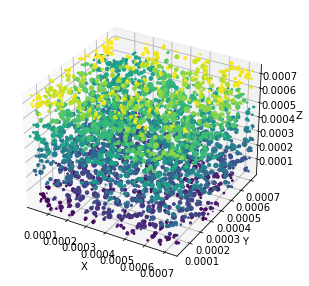

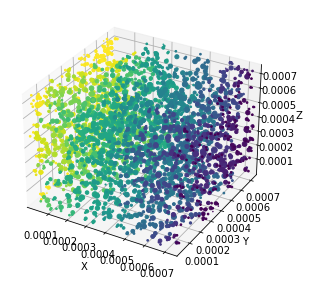

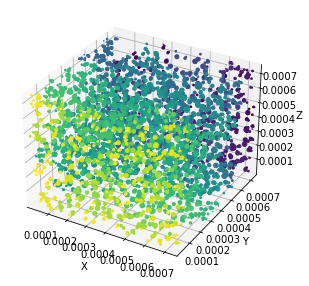

In [16]:
Pin = 1.0e5
Pout = 0.0


K_single_phase = [None,None,None]
bounds = [ ['top', 'bottom'], ['left', 'right'],['front', 'back']]
[amax, bmax, cmax] = np.max(pn['pore.coords'], axis=0)
[amin, bmin, cmin] = np.min(pn['pore.coords'], axis=0)
lx = amax-amin
ly = bmax-bmin
lz = cmax-cmin
da = lx*ly
dl = lz


def top_b(lx,ly,lz):
    da = lx*ly
    dl = lz
    res_2=[da,dl]
    return res_2

def left_r(lx,ly,lz):
    da = lx*lz
    dl = ly
    res_2=[da,dl]
    return res_2

def front_b(lx,ly,lz):
    da = ly*lz
    dl = lx
    res_2=[da,dl]
    return res_2

options = {0 : top_b(lx,ly,lz),1 : left_r(lx,ly,lz),2 : front_b(lx,ly,lz)}

for bound_increment in range(len(bounds)):
    BC1_pores = pn.pores(labels=bounds[bound_increment][0])
    BC2_pores = pn.pores(labels=bounds[bound_increment][1])
    [da,dl]=options[bound_increment]
    
    # Permeability - water
    sf = op.algorithms.StokesFlow(network=pn, phase=oil)
    sf.setup(conductance='throat.hydraulic_conductance')
    sf.set_value_BC(pores=BC1_pores, values=Pin)
    sf.set_value_BC(pores=BC2_pores, values=Pout)
    sf.run()
    K_single_phase[bound_increment] = sf.calc_effective_permeability(domain_area=da,
                                                                        domain_length=dl,
                                                                        inlets=BC1_pores,
                                                                        outlets=BC2_pores)
    fig = op.topotools.plot_coordinates(pn, color=sf['pore.pressure'], 
                                    size_by=pn['pore.diameter'], 
                                    markersize=50)

print('The permeability coefficient from top to bottom is:', K_single_phase[0])
print('The permeability coefficient from left to right is:', K_single_phase[1])
print('The permeability coefficient from front to back is:', K_single_phase[2])